In [1]:
import pandas as pd
import numpy as np

In [2]:
file_path = r"C:\Users\ASUS\Documents\Dataset ML\fr_dataset_stemmed.xlsx"
df = pd.read_excel(file_path)


In [3]:
print("Data Awal:")
print(df.head())
print("\n" + "="*50 + "\n")

Data Awal:
             category  rating label  \
0  Home_and_Kitchen_5       5    CG   
1  Home_and_Kitchen_5       5    CG   
2  Home_and_Kitchen_5       5    CG   
3  Home_and_Kitchen_5       1    CG   
4  Home_and_Kitchen_5       5    CG   

                                                text  \
0  Love this!  Well made, sturdy, and very comfor...   
1  love it, a great upgrade from the original.  I...   
2  This pillow saved my back. I love the look and...   
3  Missing information on how to use it, but it i...   
4  Very nice set. Good quality. We have had the s...   

                                          clean_text  \
0  Love this  Well made sturdy and very comfortab...   
1  love it a great upgrade from the original  Ive...   
2  This pillow saved my back I love the look and ...   
3  Missing information on how to use it but it is...   
4  Very nice set Good quality We have had the set...   

                                    clean_text_lower  \
0  love this  well made 

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
print("Mempersiapkan dan memisahkan data...")

X_text = df['stemming'].astype(str)
y = df['label']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text,
    y,
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Jumlah data latih: {len(X_train_text)}")
print(f"Jumlah data uji:  {len(X_test_text)}")
print("-" * 50)


Mempersiapkan dan memisahkan data...
Jumlah data latih: 32345
Jumlah data uji:  8087
--------------------------------------------------


In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(random_state=42,  probability=True)),
])

parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)], 
    'svm__C': [1, 10],                   
    'svm__kernel': ['linear'],             
}

grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=2)

print("Memulai Hyperparameter Tuning dengan GridSearchCV...")
print("Parameter yang akan diuji:")
print(parameters)
grid_search.fit(X_train_text, y_train)

print("\n--- Tuning Selesai ---")
print(f"Skor F1 terbaik dari hasil cross-validation: {grid_search.best_score_:.4f}")
print("Parameter terbaik yang ditemukan:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
print("-" * 50)

Memulai Hyperparameter Tuning dengan GridSearchCV...
Parameter yang akan diuji:
{'tfidf__ngram_range': [(1, 1), (1, 2)], 'svm__C': [1, 10], 'svm__kernel': ['linear']}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


   -> Prediksi selesai dibuat.

2. Menghitung dan menampilkan hasil evaluasi akhir...
   -> F1-Score (Weighted) pada Test Set: 0.9138
   -> Akurasi pada Test Set: 0.9138

--- Laporan Klasifikasi Lengkap untuk Model Terbaik ---
              precision    recall  f1-score   support

          CG       0.92      0.91      0.91      4044
          OR       0.91      0.92      0.91      4043

    accuracy                           0.91      8087
   macro avg       0.91      0.91      0.91      8087
weighted avg       0.91      0.91      0.91      8087


visualisasi Confusion Matrix untuk Model Terbaik...


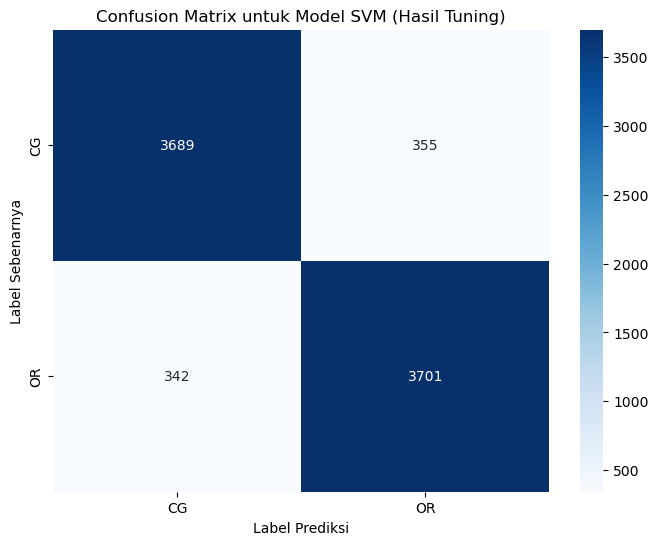

   -> Selesai.


In [11]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test_text)
print("   -> Prediksi selesai dibuat.")

print("\n2. Menghitung dan menampilkan hasil evaluasi akhir...")
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"   -> F1-Score (Weighted) pada Test Set: {f1:.4f}")

accuracy = accuracy_score(y_test, y_pred)
print(f"   -> Akurasi pada Test Set: {accuracy:.4f}")

print("\n--- Laporan Klasifikasi Lengkap untuk Model Terbaik ---")
print(classification_report(y_test, y_pred))

print("\nvisualisasi Confusion Matrix untuk Model Terbaik...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_model.classes_, 
            yticklabels=best_model.classes_)
plt.xlabel('Label Prediksi')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix untuk Model SVM (Hasil Tuning)')
plt.show()
print("   -> Selesai.")

In [13]:
!pip install lime


In [15]:
import lime
import lime.lime_text
from sklearn.pipeline import make_pipeline

class_names = best_model.classes_
explainer = lime.lime_text.LimeTextExplainer(class_names=class_names)

print("LIME Explainer siap digunakan.")

LIME Explainer siap digunakan.


In [17]:
idx_cg = 56
idx_or = 69  

text_cg = X_test_text.iloc[idx_cg]
text_or = X_test_text.iloc[idx_or]

print(f"--- Menjelaskan Ulasan #{idx_cg} ---")
print(f"Teks Ulasan: \"{text_cg}\"")
print(f"Label Sebenarnya: {y_test.iloc[idx_cg]}")
print(f"Prediksi Model: {best_model.predict([text_cg])[0]}")
print("-" * 20)


explanation_cg = explainer.explain_instance(
    text_cg, 
    best_model.predict_proba, 
    num_features=10  
)

explanation_cg.show_in_notebook(text=True)

print(f"\n\n--- Menjelaskan Ulasan #{idx_or} ---")
print(f"Teks Ulasan: \"{text_or}\"")
print(f"Label Sebenarnya: {y_test.iloc[idx_or]}")
print(f"Prediksi Model: {best_model.predict([text_or])[0]}")
print("-" * 20)

explanation_or = explainer.explain_instance(
    text_or, 
    best_model.predict_proba, 
    num_features=10
)

explanation_or.show_in_notebook(text=True)

--- Menjelaskan Ulasan #56 ---
Teks Ulasan: "love two handl nice strong not too big or too small perfect pair glass great product plastic handl great color beauti highli recommendi love iti bought replac broken one bought year ago veri disappoint not cheap but not veri good look pretti but not veri good veri thin veri hard fill given 5 star if"
Label Sebenarnya: CG
Prediksi Model: CG
--------------------


AttributeError: This 'Pipeline' has no attribute 'predict_proba'